# Implementing Monroe's Fightin' Words metric

This is an implementation of several plots from the Monroe et al. paper. The goal is to identify words that have significantly different frequency in one collection or another.

In [1]:
from collections import Counter
import regex
import numpy as np
from matplotlib import pyplot

In [2]:
word_pattern = regex.compile(r"\w+")

Here's were we convert a long string into word counts. This is really about deciding what factors do and do not have relevance to my specific study.

I noticed earlier that Hamilton seems to use "Executive" (capitalized) while Madison uses "executive". This distinction is lost when we lower-case everything. Is that important? It could be, but I'm saying that for today, it's not. We have to make decisions, the important thing is to realize that we're making decisions.

In [11]:
madison_counter = Counter()
hamilton_counter = Counter()
jay_counter = Counter()

with open("documents.txt") as reader:
    for line in reader:
        fields = line.rstrip().split("\t")
        
        if len(fields) < 3:
            continue
            
        tokens = word_pattern.findall(fields[2].lower())
        
        if "Madison" in fields[1]:
            madison_counter.update(tokens)
        if "Hamilton" in fields[1]:
            hamilton_counter.update(tokens)
        if "Jay" in fields[1]:
            jay_counter.update(tokens)

In [12]:
madison_counter.most_common(10)

[('the', 6529),
 ('of', 3942),
 ('to', 2096),
 ('and', 1887),
 ('in', 1421),
 ('a', 1361),
 ('be', 1349),
 ('that', 911),
 ('it', 844),
 ('is', 791)]

In [13]:
hamilton_counter.most_common(10)

[('the', 10301),
 ('of', 7049),
 ('to', 4259),
 ('and', 2726),
 ('in', 2653),
 ('a', 2460),
 ('be', 2315),
 ('that', 1576),
 ('it', 1456),
 ('is', 1201)]

In [14]:
jay_counter.most_common(10)

[('the', 516),
 ('and', 408),
 ('of', 359),
 ('to', 288),
 ('in', 164),
 ('be', 159),
 ('that', 150),
 ('it', 138),
 ('as', 102),
 ('a', 99)]

In [15]:
# The Counter class allows cool counter arithmetic

all_counter = madison_counter + hamilton_counter + jay_counter

In [16]:
vocabulary = list(all_counter.keys())

In [17]:
len(vocabulary)

8151

In [18]:
# keys() returns words in the order they were added, in this case
# for the Madison counter. If we want to sort, use most_common()

print(vocabulary[:20], vocabulary[-20:])

['among', 'the', 'numerous', 'advantages', 'promised', 'by', 'a', 'well', 'constructed', 'union', 'none', 'deserves', 'to', 'be', 'more', 'accurately', 'developed', 'than', 'its', 'tendency'] ['disposing', 'tides', 'days', 'intervening', 'cabinet', 'inexcusably', 'displeased', 'judgments', 'averse', 'repealable', 'amend', 'cancel', 'bile', 'casts', 'corruptly', 'punished', 'advancing', 'supposable', 'null', 'reputations']


In [19]:
# another great thing about Counter vs dict: it doesn't 
# freak out if you ask for something it doesn't know about,
# it just gives you 0

# a common pattern I use: use zeros() to allocate space for
# a matrix, then fill it.

word_counts = np.zeros((len(vocabulary), 3))

for row, word in enumerate(vocabulary):
    word_counts[row,0] = madison_counter[word]
    word_counts[row,1] = hamilton_counter[word]
    word_counts[row,2] = jay_counter[word]

In [20]:
# Numpy by default uses scientific notation, I want decimals

np.set_printoptions(suppress=True)

In [21]:
word_counts[:10,:]

array([[   73.,    57.,     3.],
       [ 6529., 10301.,   516.],
       [   35.,    52.,     0.],
       [   16.,    31.,     2.],
       [    1.,     1.,     0.],
       [  783.,   926.,    82.],
       [ 1361.,  2460.,    99.],
       [   76.,   126.,    25.],
       [    4.,     2.,     0.],
       [   97.,   212.,    22.]])

In [22]:
# .sum(axis=0) sums along columns (ie [row,col])

author_sums = word_counts.sum(axis=0)

# Use np.newaxis to streeeeetch an array to the shape of
# another array
word_proportions = word_counts / author_sums[np.newaxis,:]

# Hamilton writes more than Madison, Jay left to pursue other interests
author_sums

array([ 66481., 110854.,   8382.])

In [23]:
# most probabilities are small, but note the hard 0s

word_proportions[:10,:]

array([[0.00109806, 0.00051419, 0.00035791],
       [0.09820851, 0.09292403, 0.06156049],
       [0.00052647, 0.00046909, 0.        ],
       [0.00024067, 0.00027965, 0.00023861],
       [0.00001504, 0.00000902, 0.        ],
       [0.0117778 , 0.00835333, 0.00978287],
       [0.02047201, 0.02219135, 0.01181102],
       [0.00114318, 0.00113663, 0.00298258],
       [0.00006017, 0.00001804, 0.        ],
       [0.00145906, 0.00191243, 0.00262467]])

In [24]:
# What are the odds? p(w) / p(not w) = p(w) / (1-p(w))

word_odds = word_counts / (author_sums[np.newaxis,:] - word_counts)
word_odds[:10,:]

array([[0.00109927, 0.00051445, 0.00035804],
       [0.10890379, 0.10244349, 0.06559878],
       [0.00052674, 0.00046931, 0.        ],
       [0.00024073, 0.00027973, 0.00023866],
       [0.00001504, 0.00000902, 0.        ],
       [0.01191817, 0.0084237 , 0.00987952],
       [0.02089988, 0.02269498, 0.01195219],
       [0.00114449, 0.00113792, 0.0029915 ],
       [0.00006017, 0.00001804, 0.        ],
       [0.0014612 , 0.00191609, 0.00263158]])

In [25]:
# me verifying that the odds were being calculated correctly, for a 
# slightly different vocab size

2 / 66375

3.0131826741996233e-05

In [26]:
2 / 66373

3.0132734696337366e-05

In [27]:
# get the *log* frequency of words to use as the x-axis for plots

# axis 0 in [row,col] is along rows, axis 1 is along columns
# to be clear: sum -> *along* -> columns to get the sum for each row

type_frequencies = word_counts.sum(axis=1)
log_type_frequencies = np.log(type_frequencies)

In [28]:
def plot_words(y_value):
    y_std = y_value.std()
    pyplot.figure(figsize=(6,18))
    pyplot.scatter(log_type_frequencies, y_value, alpha=0.3)
    for i in range(len(vocabulary)):
        if np.abs(y_value[i]) > 2 * y_std:
            pyplot.text(log_type_frequencies[i], y_value[i], vocabulary[i])
    pyplot.show()

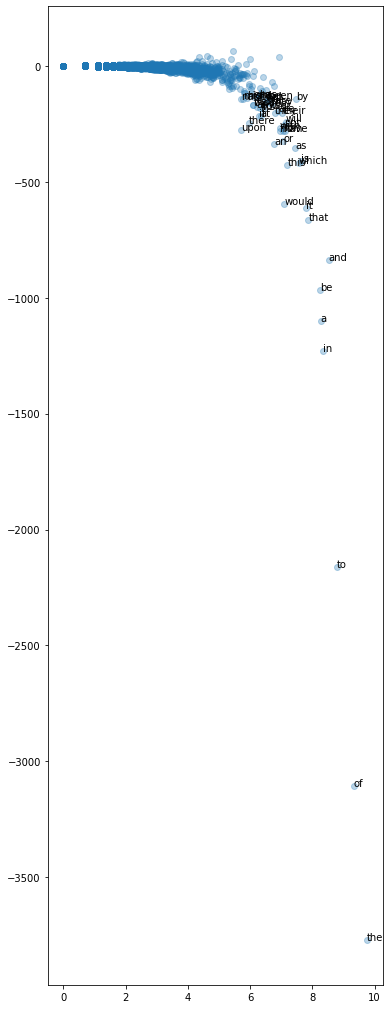

In [29]:
# raw counts aren't very interesting -- Hamilton [1] writes more
# than Madison [0]

plot_words(word_counts[:,0] - word_counts[:,1])

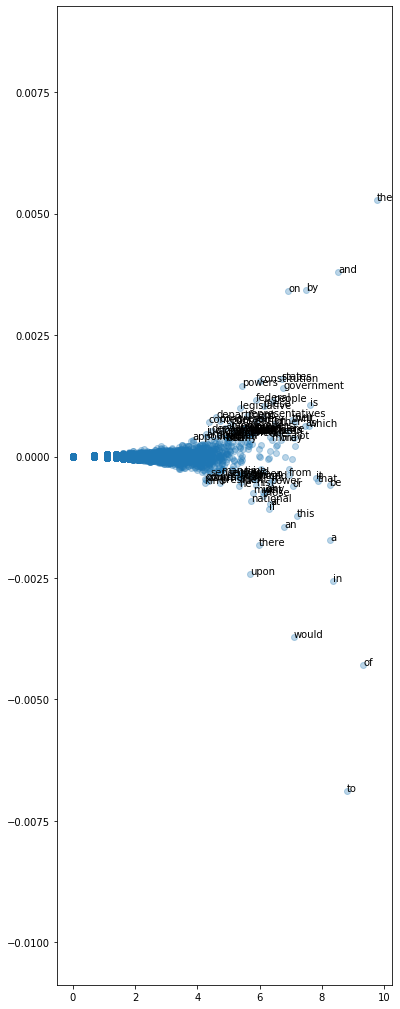

In [30]:
# the difference in proportion emphasizes high-frequency words
# (low-frequency words are always close to 0)

plot_words(word_proportions[:,0] - word_proportions[:,1])

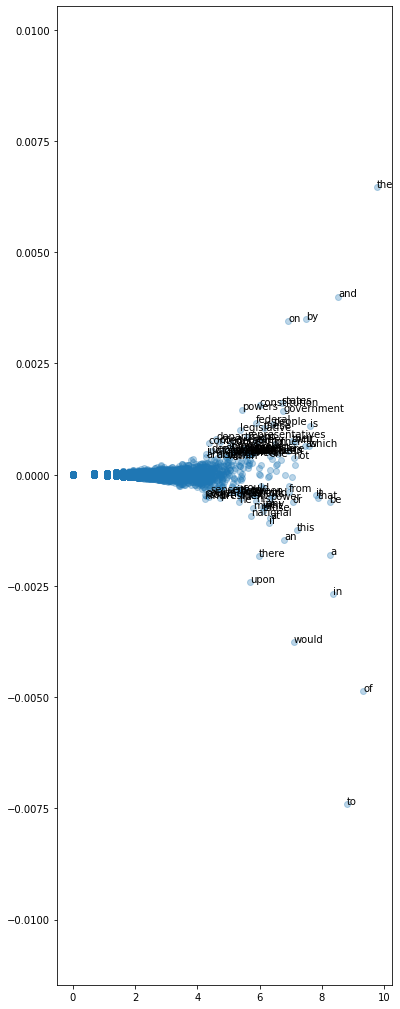

In [31]:
# odds are very close to proportions

plot_words(word_odds[:,0] - word_odds[:,1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


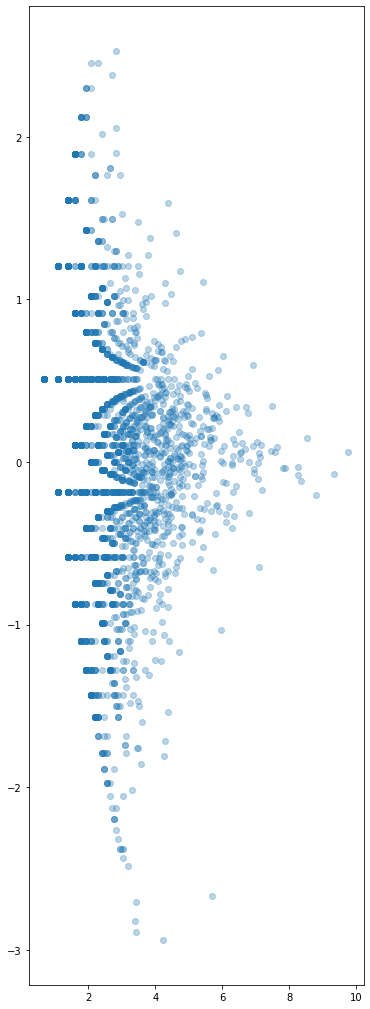

In [32]:
# the log odds ratio blows up because we have 0s

plot_words(np.log(word_odds[:,0] / word_odds[:,1]))

## Smoothing to avoid 0s

When we make a distribution by dividing a set of counts by their sum, we risk adding 0s. One way to avoid this is to add a non-zero value to each element of the array and then divide by the new sum (including the added values). This makes distributions "smoother".

We'll see a lot more about this, but for now note the effect of adding constants of different magnitudes on the resulting distribution.

Orange = actual observations, Blue = smoothing. The total size of the bar is the smoothed distribution.

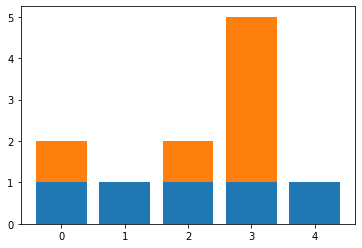

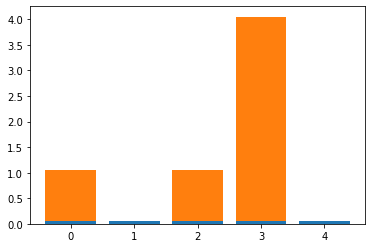

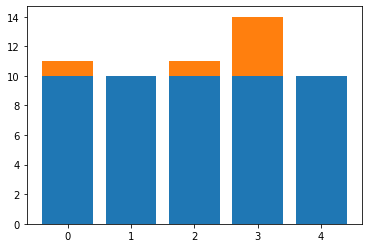

In [55]:
sparse_array = np.array([1,0,1,4,0])
smoothing = 1.0 * np.array([1,1,1,1,1])
pyplot.bar(range(5), smoothing)
pyplot.bar(range(5), sparse_array, bottom=smoothing)
pyplot.show()

smoothing = 0.05 * np.array([1,1,1,1,1])
pyplot.bar(range(5), smoothing)
pyplot.bar(range(5), sparse_array, bottom=smoothing)
pyplot.show()

smoothing = 10.0 * np.array([1,1,1,1,1])
pyplot.bar(range(5), smoothing)
pyplot.bar(range(5), sparse_array, bottom=smoothing)
pyplot.show()

In [36]:
smoothed_word_counts = word_counts + 1.0
smoothed_author_sums = smoothed_word_counts.sum(axis=0)
smoothed_word_odds = smoothed_word_counts / (smoothed_author_sums[np.newaxis,:] - smoothed_word_counts)
smoothed_word_odds[:10,:]

array([[0.00099252, 0.00048761, 0.000242  ],
       [0.09588558, 0.09477199, 0.03228022],
       [0.0004826 , 0.00044556, 0.00006049],
       [0.00022784, 0.00026897, 0.00018149],
       [0.0000268 , 0.00001681, 0.00006049],
       [0.0106164 , 0.00785074, 0.00504559],
       [0.01858878, 0.02111649, 0.00608532],
       [0.00103279, 0.00106832, 0.00157509],
       [0.000067  , 0.00002521, 0.00006049],
       [0.00131484, 0.00179305, 0.0013931 ]])

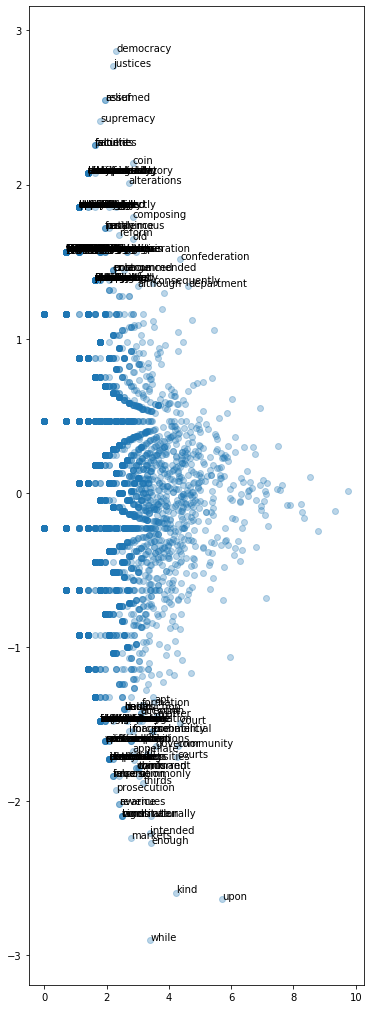

In [37]:
# Unlike proportions, log odds ratios emphasize rare words

plot_words(np.log(smoothed_word_odds[:,0] / smoothed_word_odds[:,1]))

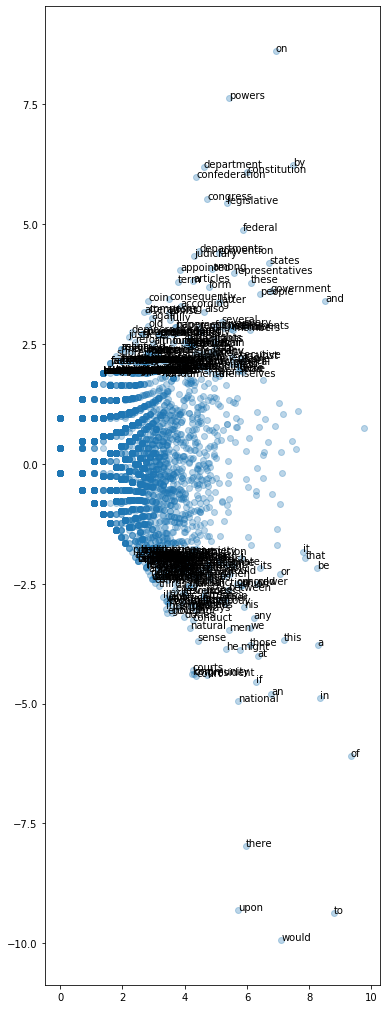

In [38]:
# For the final part of Fightin' Words, divide each log-odds-ratio by 
# an estimate of its variance. (See derivation for details).

# Think about how this variance term affects rare words and more 
# frequent words.

log_odds_difference = np.log(smoothed_word_odds[:,0] / smoothed_word_odds[:,1])
log_odds_variances = 1.0 / smoothed_word_counts[:,0] + 1.0 / smoothed_word_counts[:,1]

plot_words(log_odds_difference / np.sqrt(log_odds_variances))

Visualizing lots of words can be difficult. Notice which words your eye is drawn to and which you can't even make out. We often use list views for greater browsability.

In [53]:
def sort_words(scores, n=20):
    sorted_pairs = sorted(zip(scores, vocabulary))
    sorted_words = [w for s,w in sorted_pairs]
    print("[most negative] ", ", ".join(sorted_words[:n]))
    print("...")
    print(", ".join(sorted_words[-n:]), " [most positive]")

In [54]:
sort_words(log_odds_difference / np.sqrt(log_odds_variances), 100)

[most negative]  would, to, upon, there, of, national, in, an, if, court, president, community, kind, courts, at, might, he, a, those, sense, this, men, we, natural, conduct, any, duties, enough, governor, always, matter, intended, his, happen, sometimes, him, commercial, probability, body, man, military, naturally, office, while, either, apt, situation, us, ill, often, exist, revenue, resources, respect, easy, between, making, thirds, union, jurisdiction, militia, should, our, power, execution, commonly, strong, war, causes, command, concurrent, think, wants, serve, thing, entirely, britain, when, exclusion, king, necessities, account, direction, answer, or, could, afford, plan, york, land, appellate, considerable, formation, course, army, duty, operations, its, be, taxes
...
post, pronounced, recommended, forty, partly, residence, unanimous, violence, same, task, establishment, here, throughout, against, executive, supremacy, years, majority, many, elected, thirty, definition, voice,